# Classify Documents

In [0]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Load Data

In [0]:
!pip install -r /Workspace/Repos/jeanpierre.vanniekerk@truenorthgroup.co.za/document-analysis-using-gpt-3.ide/notebooks/requirements.txt

  Using cached azure_identity-1.6.0-py2.py3-none-any.whl (108 kB)
  Using cached streamlit-1.18.1-py2.py3-none-any.whl (9.6 MB)
  Using cached openai-0.27.8-py3-none-any.whl (73 kB)
  Using cached python_dotenv-0.21.0-py3-none-any.whl (18 kB)
  Using cached matplotlib-3.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached plotly-5.12.0-py2.py3-none-any.whl (15.2 MB)
  Using cached scipy-1.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Using cached scikit_learn-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
  Using cached tiktoken-0.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached llama_index-0.4.33-py3-none-any.whl
  Using cached langchain-0.0.129-py3-none-any.whl (467 kB)
  Using cached faiss_cpu-1.7.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Using cached msal-1.23.0-py2.py3-none-any.whl (90 kB)
  Using cached msal_extensions-0.

In [0]:
import pandas as pd
df = spark.sql('select * from openai.document_analysis_embeddings').toPandas()

In [0]:
# drop rows with NaN
df.dropna(inplace=True)
len(df)

2225

## Classify documents with their embeddings
ref: https://github.com/openai/openai-cookbook/blob/main/examples/Classification_using_embeddings.ipynb

In [0]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# convert string to array
# df["embedding"] = df['embedding'].apply(eval).apply(np.array)  

# df.info()

In [0]:
X = df['embedding']

map_dict = {"business": 0, "entertainment":1, "politics":2, "sport":3, "tech":4}
df['category'].replace(map_dict, inplace=True)

y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y) 

# reshape X into 2D array
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

## Fit a model with `XGBoost`

In [0]:
from xgboost import XGBClassifier
import pickle

TRAIN = True
LOAD = False

# filename for trained model
fname = '../output/models/xgb.pkl'

if TRAIN: 
    # create model instance
    xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=1, objective='multi:softprob')
    # fit model
    xgb.fit(X_train, y_train)

    # save the model to disk
    # with open(fname, "wb") as f:
    #     pickle.dump(xgb, f)
 
# load the model from disk
if LOAD:
    with open(fname, "rb") as f:
        xgb = pickle.load(f)

# predict
preds = xgb.predict(X_test)
probas = xgb.predict_proba(X_test)

# report
report = classification_report(y_test, preds)
print(report)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       168
           1       0.98      0.94      0.96       128
           2       0.94      0.95      0.95       138
           3       0.94      0.99      0.97       169
           4       0.95      0.95      0.95       132

    accuracy                           0.95       735
   macro avg       0.95      0.95      0.95       735
weighted avg       0.95      0.95      0.95       735



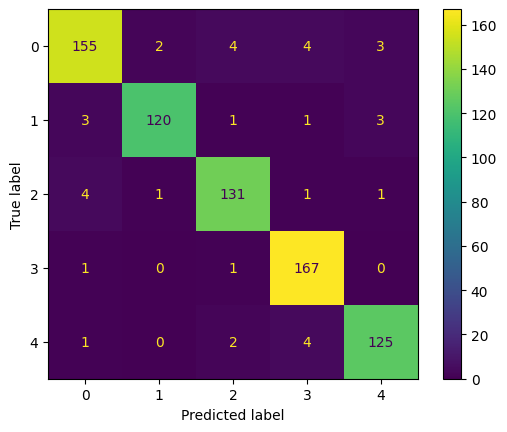

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
cm = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_).plot()


## Fit a model with `RandomForest`

In [0]:
TRAIN = True
LOAD = False
# filename for trained model
fname = '../output/models/rf.pkl'

# fit model
if TRAIN: 
    # train random forest classifier
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    # # save the model to disk
    # with open(fname, "wb") as f:
    #     pickle.dump(rf, f)
 
# load the model from disk
if LOAD:
    with open(fname, "rb") as f:
        rf = pickle.load(f)

# predict
rf_preds = rf.predict(X_test)
rf_probas = rf.predict_proba(X_test)

# report
rf_report = classification_report(y_test, rf_preds)
print(rf_report)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       168
           1       0.97      0.97      0.97       128
           2       0.94      0.95      0.95       138
           3       0.99      1.00      1.00       169
           4       0.94      0.96      0.95       132

    accuracy                           0.96       735
   macro avg       0.96      0.96      0.96       735
weighted avg       0.96      0.96      0.96       735



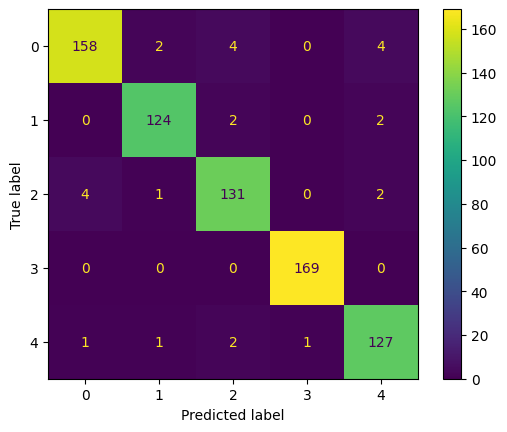

In [0]:
# Confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)
rf_cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf.classes_).plot()

## Save prediction

In [0]:
y_test_pred = pd.DataFrame()
y_test_pred['category'] = y_test
y_test_pred['prediction'] = preds
y_test_pred

,category,prediction
1897,0,0
949,3,3
1516,0,0
145,1,1
1532,0,0
...,...,...
1046,3,3
2169,1,1
1488,0,0
1348,4,4


In [0]:
df_test_result = pd.concat([df, y_test_pred.drop(columns='category')], axis=1, join="inner")
# df_test_result.shape
df_test_result1 = spark.createDataFrame(df_test_result)
df_test_result1.write.mode('overwrite').option("overwriteSchema", "true").saveAsTable('openai.document_analysis_predictions')
df_test_result1.toPandas()

,category,filename,title,content,embedding,n_tokens,prediction
0,1,232.txt,Connick Jr to lead Broadway show,""" Singer and actor Harry Connick Jr is to star...","[-0.0013730002101510763, -0.03857267275452614,...",254,1
1,1,236.txt,Franz Ferdinand's art school lesson,""" Scottish rock band Franz Ferdinand, who shot...","[-0.00918667670339346, 0.002770294900983572, 0...",694,1
2,1,238.txt,Portishead back after eight years,""" Cult British group Portishead have revealed ...","[-0.01821870543062687, -0.02119753137230873, -...",329,1
3,1,240.txt,Elvis 'set for chart hat-trick',The late US legend Elvis Presley is likely to...,"[-0.02780121937394142, -0.010392170399427414, ...",318,1
4,1,243.txt,Blue beat U2 to top France honour,""" Irish band U2 have been honoured at France's...","[-0.021403657272458076, -0.013215591199696064,...",249,1
...,...,...,...,...,...,...,...
730,1,216.txt,Housewives lift Channel 4 ratings,The debut of US television hit Desperate Hous...,"[-0.011799545027315617, -0.002670041983947158,...",247,1
731,1,217.txt,Baywatch dubbed 'worst TV import',""" Surf show Baywatch has won the title of wors...","[0.010634999722242355, -0.025023529306054115, ...",255,1
732,1,225.txt,Stallone evicted from Big Brother,""" Jackie Stallone, mother of actor Sylvester, ...","[-0.0064085135236382484, -0.010845176875591278...",387,1
733,1,227.txt,George Michael to perform for BBC,""" George Michael is to perform live at London'...","[-0.0173494815826416, -0.017017800360918045, -...",264,1


## Wrong Predictions

In [0]:
import pyspark.sql.functions as psf
df_wrong_predictions = spark.sql('select * from openai.document_analysis_predictions').where(psf.col('category') != psf.col('prediction'))
df_wrong_predictions.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("openai.document_analysis_wrong_predictions")
df_wrong_predictions.toPandas()

,category,filename,title,content,embedding,n_tokens,prediction
0,1,266.txt,Help for indies in download sales,""" A campaign has been launched to help indepen...","[-0.029400071129202843, -0.015044981613755226,...",215,4
1,1,321.txt,UK 'world's biggest music buyer',""" UK consumers are the biggest music buyers in...","[-0.009967980906367302, -0.024538539350032806,...",486,0
2,2,006.txt,'Errors' doomed first Dome sale,""" The initial attempt to sell the Millennium D...","[-0.0060406760312616825, -0.013089250773191452...",396,0
3,2,023.txt,E-University 'disgraceful waste',""" A failed government scheme to offer UK unive...","[-0.014886823482811451, -0.027123846113681793,...",408,0
4,2,076.txt,Report attacks defence spending,""" The Ministry of Defence has been criticised ...","[-0.010466538369655609, -0.023837164044380188,...",502,0
5,2,109.txt,UK firms 'embracing e-commerce',""" UK firms are embracing internet trading oppo...","[-0.012539582327008247, -0.017875855788588524,...",359,4
6,2,113.txt,MP's shock at long lost daughter,""" Labour MP Stephen Pound has told of his shoc...","[-0.004390070214867592, -0.0006373095093294978...",405,1
7,2,138.txt,EU fraud clampdown urged,""" EU member states are failing to report fraud...","[0.009999867528676987, -0.026863398030400276, ...",494,0
8,2,259.txt,'Poll Idols' face first hurdles,""" Vote For Me - ITV1's Pop Idol style talent c...","[-0.010915814898908138, -0.013232310302555561,...",901,3
9,3,148.txt,Palace threat over Cantona masks,""" Manchester United fans wearing Eric Cantona ...","[-0.009764520451426506, -0.01581239514052868, ...",192,2
